!git clone git@github.com:deliveryhero/mkt-casestudy-ds.git

In [140]:
import gzip
import shutil
import pandas as pd

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import squarify
from sklearn.cluster import KMeans
import time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mlxtend.frequent_patterns import fpgrowth
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, \
                             classification_report, confusion_matrix, make_scorer,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import graphviz
import copy

from operator import attrgetter
import matplotlib.colors as mcolors

from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [2]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
    
def plot_categorical_hist(df, max_num_of_levels=15):
    df_value_counts = df.apply(pd.value_counts)

    for col in df_value_counts.columns:
        values = df_value_counts[col]
        values = values[~pd.isnull(values)]

        if len(values) > max_num_of_levels:
            continue
    
        plt.bar(range(len(values)), values)
        plt.title(col)
        plt.show()

In [238]:
def metric_check(model_obj,xtrain,xtest,ytrain,ytest):
    
    print('Train recall: ',recall_score(ytrain, model_obj.predict(xtrain)))
    print('Test recall: ',recall_score(ytest, model_obj.predict(xtest)),'\n')

    print('Train precision: ',precision_score(ytrain, model_obj.predict(xtrain)))
    print('Test precision: ',precision_score(ytest, model_obj.predict(xtest)),'\n')

    print('Train accuracy: ', accuracy_score(ytrain, model_obj.predict(xtrain)))
    print('Test accuracy: ', accuracy_score(ytest, model_obj.predict(xtest)),'\n')

    
    plt.figure(figsize=(9,9))
    sns.heatmap(confusion_matrix(ytrain, model_obj.predict(xtrain)), 
                annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.title('Train confusion matrix')
    plt.show()
    

    plt.figure(figsize=(9,9))
    sns.heatmap(confusion_matrix(ytest, model_obj.predict(xtest)), 
                annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.title('Test confusion matrix')
    plt.show()

def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

# Data Import

In [3]:
with gzip.open('mkt-casestudy-ds/data/machine_learning_challenge_labeled_data.csv.gz') as f:

    labeled_data = pd.read_csv(f)

with gzip.open('mkt-casestudy-ds/data/machine_learning_challenge_order_data.csv.gz') as f:

    order_data = pd.read_csv(f)
    
print(labeled_data.shape)

print(order_data.shape)

(245455, 2)
(786600, 13)


In [4]:
labeled_data.head()

,customer_id,is_returning_customer
0,000097eabfd9,0
1,0000e2c6d9be,0
2,000133bb597f,1
3,00018269939b,0
4,0001a00468a6,0


In [6]:
order_data.head()

,customer_id,order_date,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id
0,000097eabfd9,2015-06-20,19,1.0,0,0.0,0.000,11.46960,5803498,20326,1779,30231,4356
1,0000e2c6d9be,2016-01-29,20,1.0,0,0.0,0.000,9.55800,239303498,76547,1619,30359,4356
2,000133bb597f,2017-02-26,19,1.0,0,0.0,0.493,5.93658,206463498,33833,1619,30359,4324
3,00018269939b,2017-02-05,17,1.0,0,0.0,0.493,9.82350,36613498,99315,1619,30359,4356
4,0001a00468a6,2015-08-04,19,1.0,0,0.0,0.493,5.15070,225853498,16456,1619,29463,4356


In [7]:
order_data.dtypes

customer_id             object
order_date              object
order_hour               int64
customer_order_rank    float64
is_failed                int64
voucher_amount         float64
delivery_fee           float64
amount_paid            float64
restaurant_id            int64
city_id                  int64
payment_id               int64
platform_id              int64
transmission_id          int64
dtype: object

In [8]:
df_merge=order_data.merge(labeled_data,how='left',on='customer_id')

In [9]:
print(df_merge.shape,'\n')
print(df_merge['is_returning_customer'].value_counts())

(786600, 14) 

1    408889
0    377711
Name: is_returning_customer, dtype: int64


# Data Discovery

In [10]:
df_merge.head()

,customer_id,order_date,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id,is_returning_customer
0,000097eabfd9,2015-06-20,19,1.0,0,0.0,0.000,11.46960,5803498,20326,1779,30231,4356,0
1,0000e2c6d9be,2016-01-29,20,1.0,0,0.0,0.000,9.55800,239303498,76547,1619,30359,4356,0
2,000133bb597f,2017-02-26,19,1.0,0,0.0,0.493,5.93658,206463498,33833,1619,30359,4324,1
3,00018269939b,2017-02-05,17,1.0,0,0.0,0.493,9.82350,36613498,99315,1619,30359,4356,0
4,0001a00468a6,2015-08-04,19,1.0,0,0.0,0.493,5.15070,225853498,16456,1619,29463,4356,0


In [11]:
print(df_merge['order_date'].min())
print(df_merge['order_date'].max())

2012-05-17
2017-02-27


In [14]:
df_merge2=copy.deepcopy(df_merge)

In [17]:
df_merge['order_date'] = pd.to_datetime(df_merge['order_date'])


In [18]:
df_merge['order_date_ym']=df_merge['order_date'].dt.strftime('%Y%m')
df_merge['order_date_ym'].value_counts()

201701    57021
201612    52190
201702    50619
201610    47610
201611    47129
201607    39026
201609    37641
201608    37124
201601    35983
201605    35976
201606    35764
201603    34512
201604    33158
201602    32861
201512    29375
201511    28211
201510    25970
201509    22785
201508    22130
201505    20195
201507    19668
201506    15964
201504    13256
201503    12379
201502        8
201411        4
201306        3
201310        3
201309        3
201412        3
201404        3
201308        2
201405        2
201303        2
201407        2
201401        2
201406        2
201501        2
201408        2
201208        1
201209        1
201212        1
201410        1
201311        1
201312        1
201307        1
201305        1
201205        1
201409        1
Name: order_date_ym, dtype: int64

In [24]:
df_merge=df_merge[df_merge['order_date']>='2015-03-01']
df_merge['order_date_ym'].value_counts()

201701    57021
201612    52190
201702    50619
201610    47610
201611    47129
201607    39026
201609    37641
201608    37124
201601    35983
201605    35976
201606    35764
201603    34512
201604    33158
201602    32861
201512    29375
201511    28211
201510    25970
201509    22785
201508    22130
201505    20195
201507    19668
201506    15964
201504    13256
201503    12379
Name: order_date_ym, dtype: int64

In [25]:
df_merge.columns

Index(['customer_id', 'order_date', 'order_hour', 'customer_order_rank',
       'is_failed', 'voucher_amount', 'delivery_fee', 'amount_paid',
       'restaurant_id', 'city_id', 'payment_id', 'platform_id',
       'transmission_id', 'is_returning_customer', 'order_date_ym'],
      dtype='object')

In [26]:
missing_values_table(df_merge)

Your selected dataframe has 15 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
customer_order_rank,24761,3.1


In [27]:
for col in ['restaurant_id', 'city_id', 'payment_id', 'platform_id','transmission_id']:
    print('{0} value have {1} distinct values'.format(col,df_merge[col].nunique()))

restaurant_id value have 13560 distinct values
city_id value have 3749 distinct values
payment_id value have 5 distinct values
platform_id value have 14 distinct values
transmission_id value have 10 distinct values


In [28]:
df_merge[['restaurant_id', 'city_id', 'payment_id', 'platform_id','transmission_id']]=df_merge[['restaurant_id', 'city_id', 'payment_id', 'platform_id','transmission_id']].astype('object')

In [29]:
df_merge.dtypes

customer_id                      object
order_date               datetime64[ns]
order_hour                        int64
customer_order_rank             float64
is_failed                         int64
voucher_amount                  float64
delivery_fee                    float64
amount_paid                     float64
restaurant_id                    object
city_id                          object
payment_id                       object
platform_id                      object
transmission_id                  object
is_returning_customer             int64
order_date_ym                    object
dtype: object

In [30]:
categorical_columns=['restaurant_id', 'city_id', 'payment_id', 'platform_id','transmission_id']
num_cols=['order_hour', 'customer_order_rank','is_failed', 'voucher_amount', 'delivery_fee', 'amount_paid']
target=['is_returning_customer']

## EDA

In [31]:
import copy
df_merge2=copy.deepcopy(df_merge)

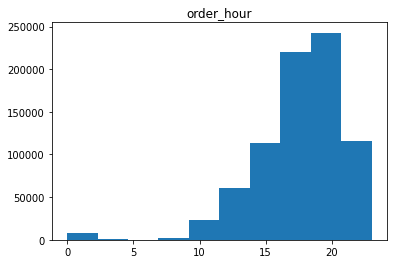

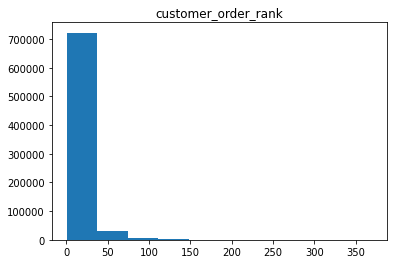

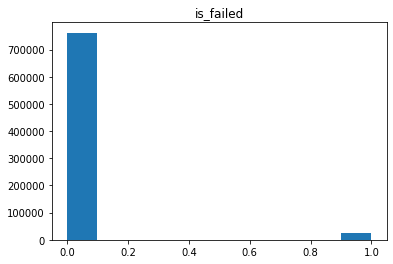

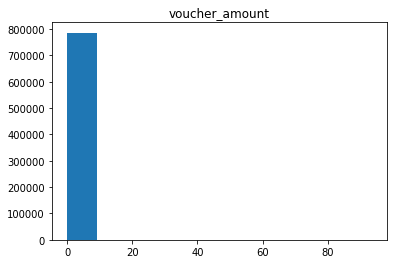

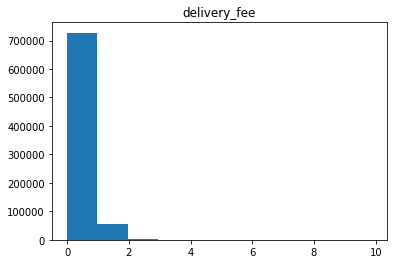

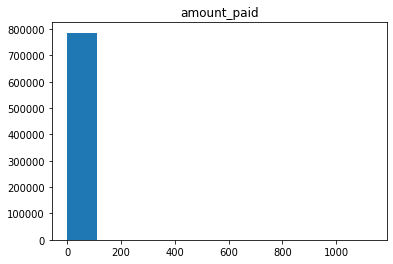

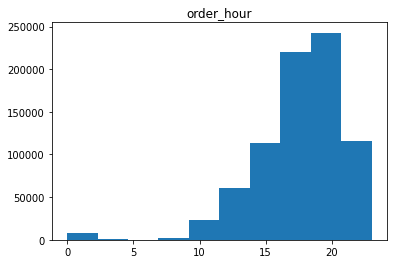

In [32]:
for index, element in enumerate(num_cols+['order_hour']):
    plt.figure(index)
    plt.hist(df_merge[element])
    plt.title(element)

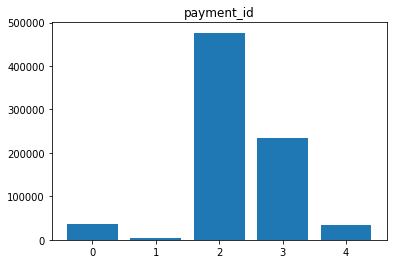

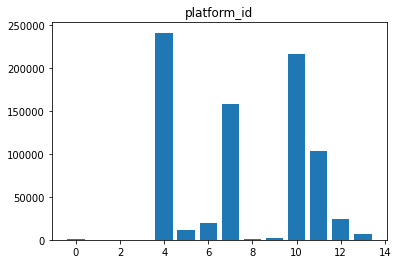

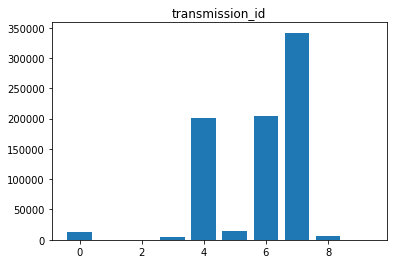

In [33]:
plot_categorical_hist(df_merge[['payment_id', 'platform_id','transmission_id']])

# Customer Level Dataset

In [34]:
df_merge['order_date'] = pd.to_datetime(df_merge['order_date'])

In [35]:
df_merge.columns

Index(['customer_id', 'order_date', 'order_hour', 'customer_order_rank',
       'is_failed', 'voucher_amount', 'delivery_fee', 'amount_paid',
       'restaurant_id', 'city_id', 'payment_id', 'platform_id',
       'transmission_id', 'is_returning_customer', 'order_date_ym'],
      dtype='object')

In [36]:
df_merge['weekday'] = df_merge['order_date'].dt.strftime('%A')
df_merge['Weekend_Flag'] = 0
df_merge.loc[(df_merge['weekday'].isin(['Saturday','Sunday'])),'Weekend_Flag'] = 1

In [37]:
dcust=df_merge.groupby('customer_id').agg({'order_date':['min','max'],
                                     'customer_id':'count',
                                     'customer_order_rank':'max',
                                     'is_failed':'sum',
                                     'voucher_amount':['mean','median','sum'],
                                     'delivery_fee':['mean','median','sum'],
                                     'amount_paid':['mean','median','sum'],
                                     'is_returning_customer':'max',
                                     'city_id':'nunique',
                                     'restaurant_id':'nunique',
                                     'order_hour':['min','max','median','nunique'],
                                     'weekday':'nunique',
                                     'Weekend_Flag':'sum'
                                    })

dcust.columns=['_'.join(col) for col in dcust.columns.ravel()]
dcust.reset_index(inplace=True)

In [38]:
dcust.head()

,customer_id,order_date_min,order_date_max,customer_id_count,customer_order_rank_max,is_failed_sum,voucher_amount_mean,voucher_amount_median,voucher_amount_sum,delivery_fee_mean,...,amount_paid_sum,is_returning_customer_max,city_id_nunique,restaurant_id_nunique,order_hour_min,order_hour_max,order_hour_median,order_hour_nunique,weekday_nunique,Weekend_Flag_sum
0,000097eabfd9,2015-06-20,2015-06-20,1,1.0,0,0.0,0.0,0.0,0.000,...,11.46960,0,1,1,19,19,19.0,1,1,1
1,0000e2c6d9be,2016-01-29,2016-01-29,1,1.0,0,0.0,0.0,0.0,0.000,...,9.55800,0,1,1,20,20,20.0,1,1,0
2,000133bb597f,2017-02-26,2017-02-26,1,1.0,0,0.0,0.0,0.0,0.493,...,5.93658,1,1,1,19,19,19.0,1,1,1
3,00018269939b,2017-02-05,2017-02-05,1,1.0,0,0.0,0.0,0.0,0.493,...,9.82350,0,1,1,17,17,17.0,1,1,1
4,0001a00468a6,2015-08-04,2015-08-04,1,1.0,0,0.0,0.0,0.0,0.493,...,5.15070,0,1,1,19,19,19.0,1,1,0


In [39]:
dcust['date_diff']=(dcust['order_date_max']-dcust['order_date_min']).dt.days

In [40]:
dcust['Recency']=(df_merge['order_date'].max()-dcust['order_date_max']).dt.days

In [41]:
dcust.columns

Index(['customer_id', 'order_date_min', 'order_date_max', 'customer_id_count',
       'customer_order_rank_max', 'is_failed_sum', 'voucher_amount_mean',
       'voucher_amount_median', 'voucher_amount_sum', 'delivery_fee_mean',
       'delivery_fee_median', 'delivery_fee_sum', 'amount_paid_mean',
       'amount_paid_median', 'amount_paid_sum', 'is_returning_customer_max',
       'city_id_nunique', 'restaurant_id_nunique', 'order_hour_min',
       'order_hour_max', 'order_hour_median', 'order_hour_nunique',
       'weekday_nunique', 'Weekend_Flag_sum', 'date_diff', 'Recency'],
      dtype='object')

## RFM Analysis

In [42]:
drfm=copy.deepcopy(dcust[['customer_id','Recency','customer_id_count','amount_paid_sum']])

drfm.columns=['customer_id','Recency','Frequency','Monetary']

quantiles = drfm[['Recency','Frequency','Monetary']].quantile(q=[0.25,0.5,0.75])

def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
quantiles.iloc[1,1]=1.5

In [43]:
drfm['R_score'] = drfm['Recency'].apply(R_Class,args=('Recency',quantiles))
drfm['F_score'] = drfm['Frequency'].apply(FM_Class,args=('Frequency',quantiles))
drfm['M_score'] = drfm['Monetary'].apply(FM_Class,args=('Monetary',quantiles))

drfm['RFM_Score'] = drfm['R_score'].map(str) + drfm['F_score'].map(str) + drfm['M_score'].map(str)

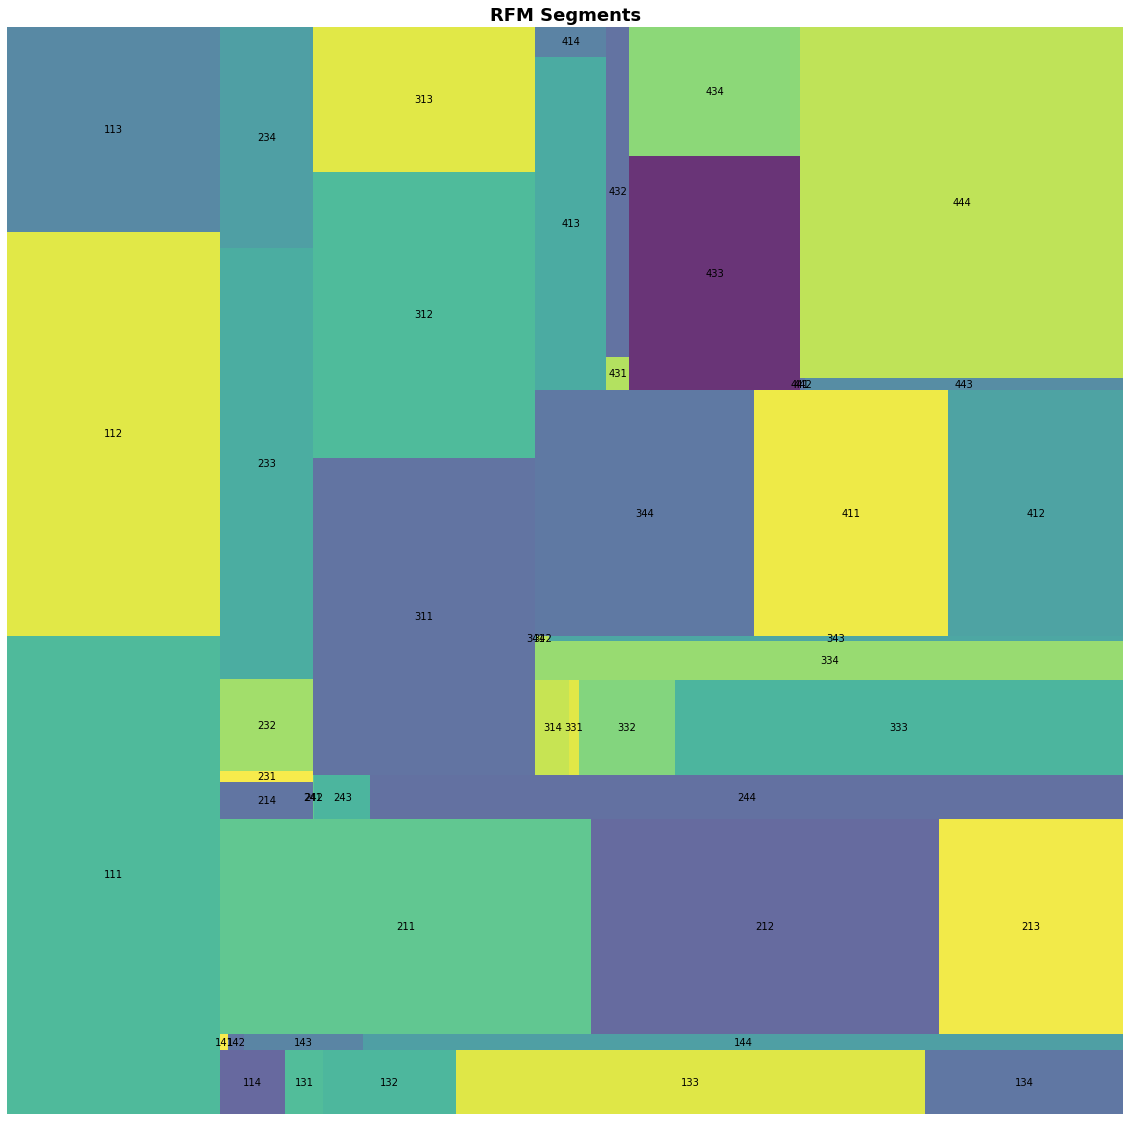

In [44]:
rfm=drfm.groupby('RFM_Score').aggregate({'Recency':'median','Monetary':'median','Frequency':'median','customer_id':'count'}).reset_index()


fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 20)

squarify.plot(sizes = rfm['customer_id'], 
              label = rfm['RFM_Score'], alpha=0.8 )

plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [45]:
dcust=dcust.merge(drfm[['customer_id','R_score','F_score','M_score','RFM_Score']],how='left')

# Correlation Map

<AxesSubplot:>

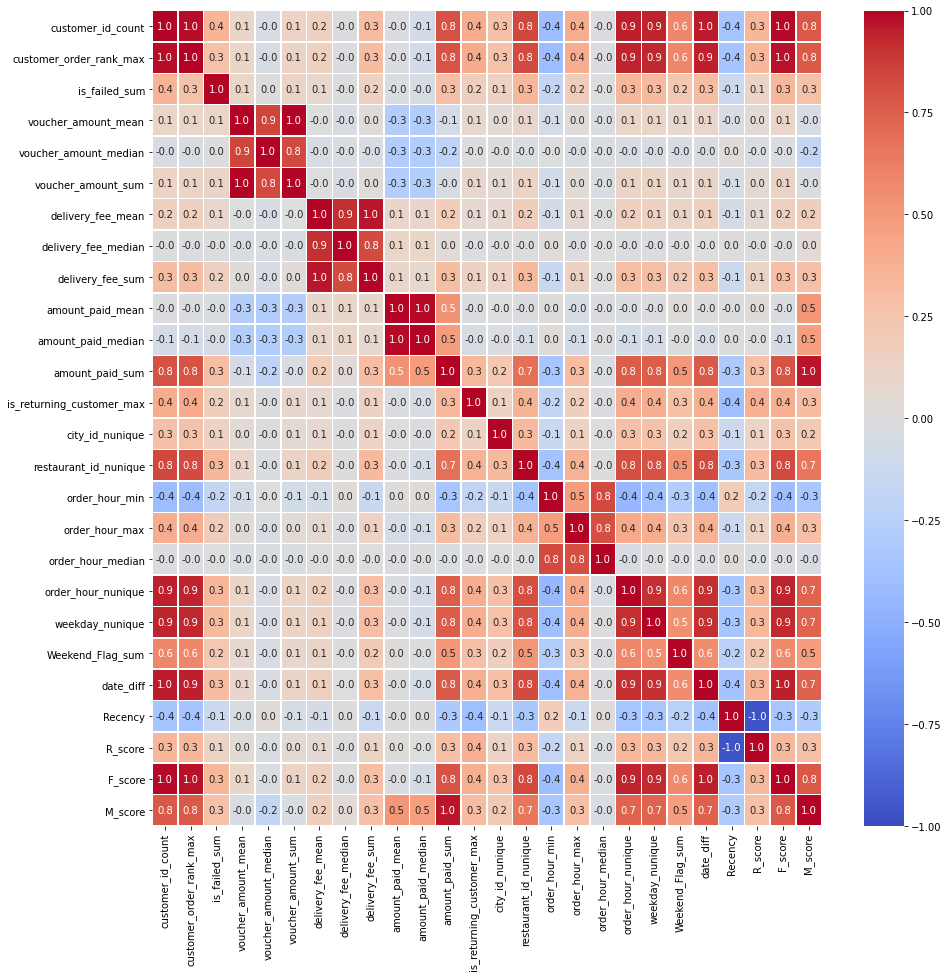

In [46]:
cols=[c for c in dcust.columns if c not in ['customer_id', 'order_date_min', 'order_date_max']]
correlation_matrix = dcust[cols].corr(method='spearman')

figure_size = (15, 15)
fig, ax = plt.subplots(figsize=figure_size)

sns.heatmap(correlation_matrix, xticklabels = list(correlation_matrix), 
            yticklabels = list(correlation_matrix),
            annot=True, fmt='.1f', linewidths = 0.5, ax=ax, vmin=-1, vmax=1, cmap='coolwarm')

## Cohort Analysis

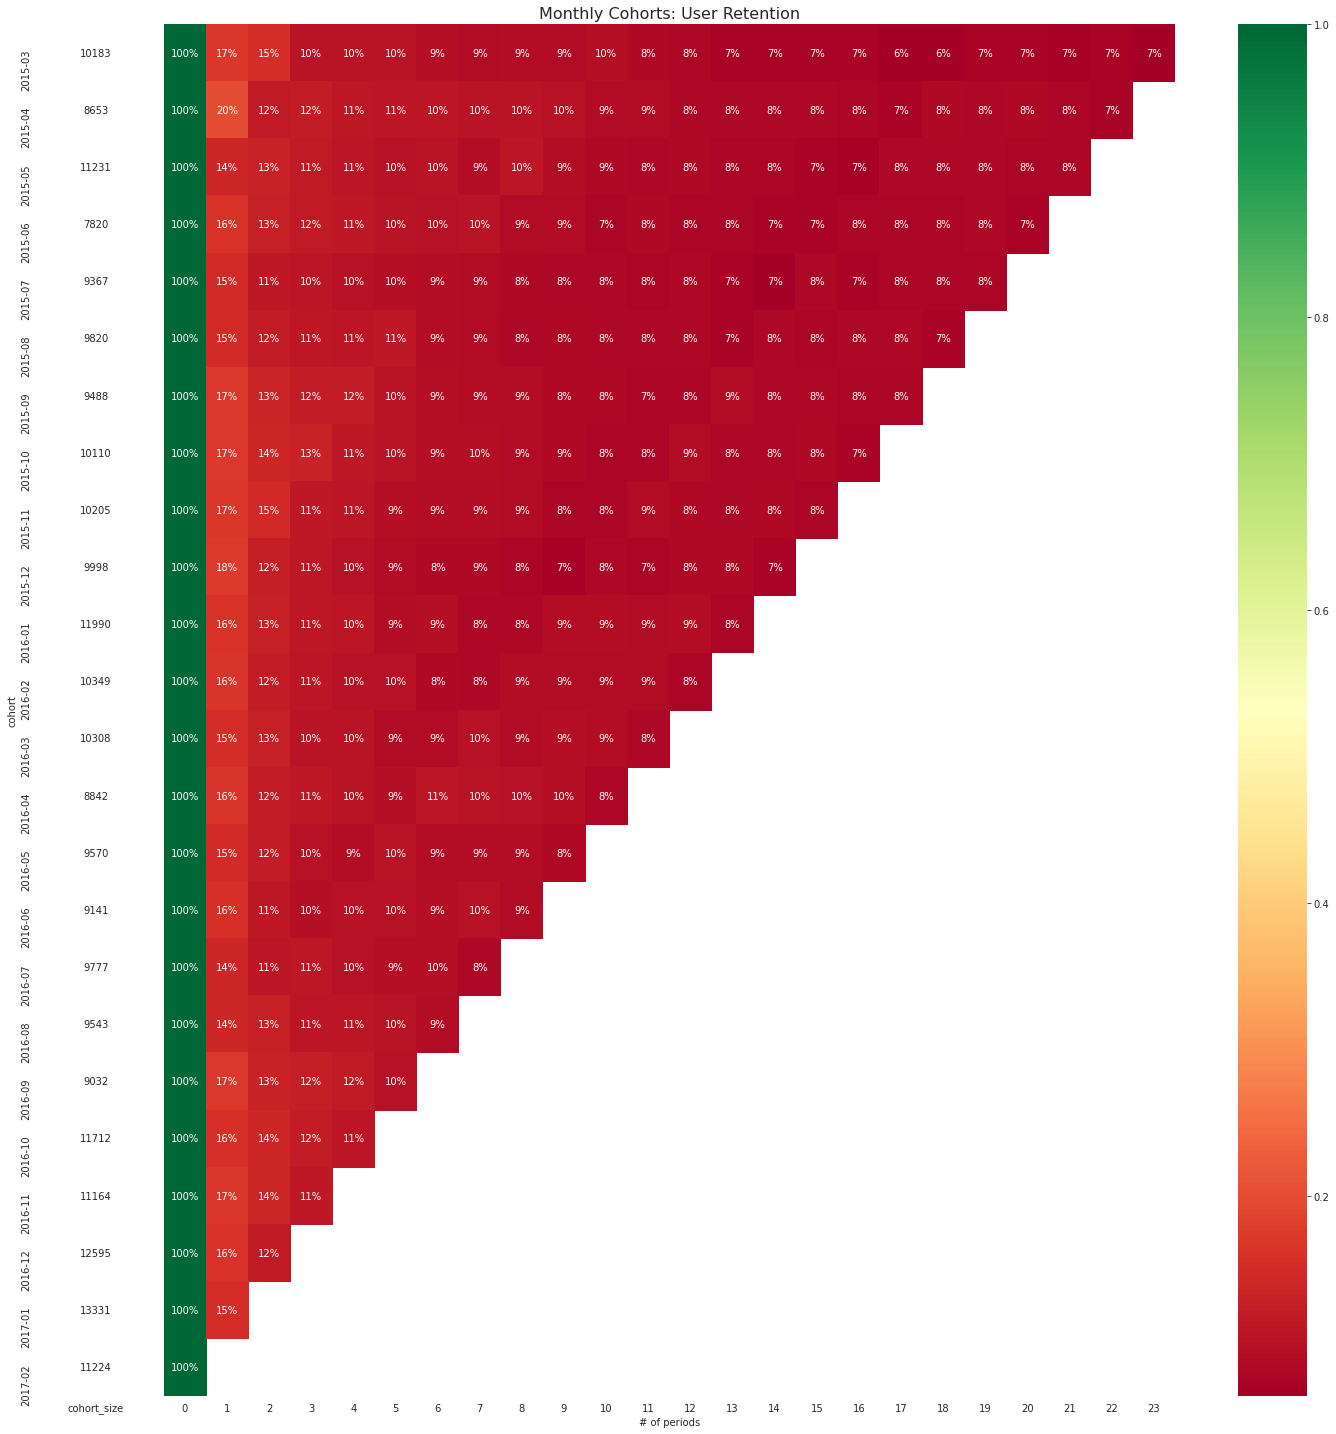

In [48]:
df_merge['Year_Month_dt']=df_merge['order_date'].dt.strftime('%Y%m')

df_merge['Year_Month_dt']=pd.to_datetime(df_merge['Year_Month_dt'].astype(str), format='%Y%m')

df_merge['cohort'] = df_merge.groupby('customer_id')['Year_Month_dt'].transform('min').dt.to_period('M') 

df_cohort = df_merge.groupby(['cohort', 'Year_Month_dt']).agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['Year_Month_dt']=df_cohort['Year_Month_dt'].dt.to_period('M') 
df_cohort = df_cohort[df_cohort['cohort']>'2015-01']


df_cohort['period_number'] = (df_cohort.Year_Month_dt - df_cohort.cohort).apply(attrgetter('n'))



cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 20), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

## Base Model

From start to detailed feature engineering and data wrangling more i would like to check the baseline information involving data

In [52]:
dcust['is_returning_customer_max'].value_counts()

0    189948
1     55505
Name: is_returning_customer_max, dtype: int64

In [53]:
dcust.columns

Index(['customer_id', 'order_date_min', 'order_date_max', 'customer_id_count',
       'customer_order_rank_max', 'is_failed_sum', 'voucher_amount_mean',
       'voucher_amount_median', 'voucher_amount_sum', 'delivery_fee_mean',
       'delivery_fee_median', 'delivery_fee_sum', 'amount_paid_mean',
       'amount_paid_median', 'amount_paid_sum', 'is_returning_customer_max',
       'city_id_nunique', 'restaurant_id_nunique', 'order_hour_min',
       'order_hour_max', 'order_hour_median', 'order_hour_nunique',
       'weekday_nunique', 'Weekend_Flag_sum', 'date_diff', 'Recency',
       'R_score', 'F_score', 'M_score', 'RFM_Score'],
      dtype='object')

In [54]:
dcust.head(3)

,customer_id,order_date_min,order_date_max,customer_id_count,customer_order_rank_max,is_failed_sum,voucher_amount_mean,voucher_amount_median,voucher_amount_sum,delivery_fee_mean,...,order_hour_median,order_hour_nunique,weekday_nunique,Weekend_Flag_sum,date_diff,Recency,R_score,F_score,M_score,RFM_Score
0,000097eabfd9,2015-06-20,2015-06-20,1,1.0,0,0.0,0.0,0.0,0.000,...,19.0,1,1,1,0,618,1,1,2,112
1,0000e2c6d9be,2016-01-29,2016-01-29,1,1.0,0,0.0,0.0,0.0,0.000,...,20.0,1,1,0,0,395,2,1,2,212
2,000133bb597f,2017-02-26,2017-02-26,1,1.0,0,0.0,0.0,0.0,0.493,...,19.0,1,1,1,0,1,4,1,1,411


In [65]:
features = [c for c in dcust.columns if c not in ['customer_id','order_date_min,order_date_max','is_returning_customer_max']]
target =  'is_returning_customer_max'

X_train,X_test,ytrain,ytest = train_test_split(dcust[features],dcust[target],stratify=dcust[target],
                                               test_size=0.2,random_state=42)

In [66]:

model_base = CatBoostClassifier()

n = ytrain.value_counts()
model_base = CatBoostClassifier(
                           learning_rate=.1,
                           iterations=1000,
                           max_depth=5,
                           l2_leaf_reg=1,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]], custom_loss=['AUC'])

model_base.fit(
    X_train, ytrain,
    eval_set=(X_test, ytest),
    plot = True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6585578	test: 0.6588721	best: 0.6588721 (0)	total: 41.1ms	remaining: 41s
1:	learn: 0.6318652	test: 0.6322274	best: 0.6322274 (1)	total: 77.2ms	remaining: 38.5s
2:	learn: 0.6104552	test: 0.6110361	best: 0.6110361 (2)	total: 109ms	remaining: 36.2s
3:	learn: 0.5936109	test: 0.5944862	best: 0.5944862 (3)	total: 144ms	remaining: 35.7s
4:	learn: 0.5801100	test: 0.5811684	best: 0.5811684 (4)	total: 178ms	remaining: 35.5s
5:	learn: 0.5684501	test: 0.5695909	best: 0.5695909 (5)	total: 219ms	remaining: 36.2s
6:	learn: 0.5596925	test: 0.5607842	best: 0.5607842 (6)	total: 254ms	remaining: 36.1s
7:	learn: 0.5526540	test: 0.5538848	best: 0.5538848 (7)	total: 292ms	remaining: 36.3s
8:	learn: 0.5468618	test: 0.5481723	best: 0.5481723 (8)	total: 323ms	remaining: 35.6s
9:	learn: 0.5420055	test: 0.5434151	best: 0.5434151 (9)	total: 354ms	remaining: 35s
10:	learn: 0.5379115	test: 0.5393840	best: 0.5393840 (10)	total: 387ms	remaining: 34.8s
11:	learn: 0.5346560	test: 0.5361298	best: 0.5361298 (

94:	learn: 0.5123705	test: 0.5158059	best: 0.5158059 (94)	total: 3.44s	remaining: 32.8s
95:	learn: 0.5123422	test: 0.5157965	best: 0.5157965 (95)	total: 3.48s	remaining: 32.8s
96:	learn: 0.5122946	test: 0.5157624	best: 0.5157624 (96)	total: 3.52s	remaining: 32.7s
97:	learn: 0.5122621	test: 0.5157517	best: 0.5157517 (97)	total: 3.55s	remaining: 32.7s
98:	learn: 0.5122203	test: 0.5157187	best: 0.5157187 (98)	total: 3.59s	remaining: 32.7s
99:	learn: 0.5121961	test: 0.5157213	best: 0.5157187 (98)	total: 3.63s	remaining: 32.6s
100:	learn: 0.5121759	test: 0.5156998	best: 0.5156998 (100)	total: 3.66s	remaining: 32.6s
101:	learn: 0.5121627	test: 0.5156856	best: 0.5156856 (101)	total: 3.71s	remaining: 32.6s
102:	learn: 0.5121272	test: 0.5156704	best: 0.5156704 (102)	total: 3.75s	remaining: 32.6s
103:	learn: 0.5120994	test: 0.5156679	best: 0.5156679 (103)	total: 3.79s	remaining: 32.6s
104:	learn: 0.5120733	test: 0.5156486	best: 0.5156486 (104)	total: 3.82s	remaining: 32.6s
105:	learn: 0.5120481	

187:	learn: 0.5091600	test: 0.5149612	best: 0.5149099 (171)	total: 6.81s	remaining: 29.4s
188:	learn: 0.5091555	test: 0.5149597	best: 0.5149099 (171)	total: 6.84s	remaining: 29.3s
189:	learn: 0.5091459	test: 0.5149583	best: 0.5149099 (171)	total: 6.87s	remaining: 29.3s
190:	learn: 0.5091188	test: 0.5149535	best: 0.5149099 (171)	total: 6.9s	remaining: 29.2s
191:	learn: 0.5090752	test: 0.5149616	best: 0.5149099 (171)	total: 6.94s	remaining: 29.2s
192:	learn: 0.5090436	test: 0.5149573	best: 0.5149099 (171)	total: 6.97s	remaining: 29.1s
193:	learn: 0.5090185	test: 0.5149922	best: 0.5149099 (171)	total: 7.01s	remaining: 29.1s
194:	learn: 0.5089984	test: 0.5149920	best: 0.5149099 (171)	total: 7.04s	remaining: 29.1s
195:	learn: 0.5089508	test: 0.5149944	best: 0.5149099 (171)	total: 7.08s	remaining: 29s
196:	learn: 0.5089352	test: 0.5149945	best: 0.5149099 (171)	total: 7.12s	remaining: 29s
197:	learn: 0.5088930	test: 0.5149700	best: 0.5149099 (171)	total: 7.16s	remaining: 29s
198:	learn: 0.508

Train recall:  0.6892622286280515
Test recall:  0.6821007116475993 

Train precision:  0.5122686037559
Test precision:  0.5111726186457841 

Train accuracy:  0.7813324370295679
Test accuracy:  0.7806115173860789 



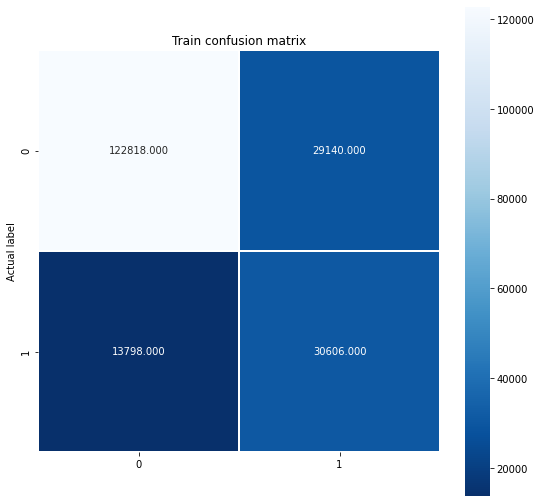

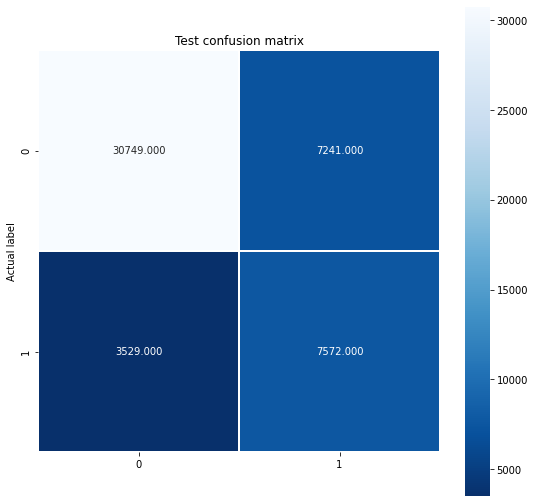

In [91]:
metric_check(model_base,X_train,X_test,ytrain,ytest)

# Improve the Model 

# Feature Engineering

In [94]:
dcust_v2=copy.deepcopy(dcust)

In [92]:
dcust.head(3)

,customer_id,order_date_min,order_date_max,customer_id_count,customer_order_rank_max,is_failed_sum,voucher_amount_mean,voucher_amount_median,voucher_amount_sum,delivery_fee_mean,...,order_hour_median,order_hour_nunique,weekday_nunique,Weekend_Flag_sum,date_diff,Recency,R_score,F_score,M_score,RFM_Score
0,000097eabfd9,2015-06-20,2015-06-20,1,1.0,0,0.0,0.0,0.0,0.000,...,19.0,1,1,1,0,618,1,1,2,112
1,0000e2c6d9be,2016-01-29,2016-01-29,1,1.0,0,0.0,0.0,0.0,0.000,...,20.0,1,1,0,0,395,2,1,2,212
2,000133bb597f,2017-02-26,2017-02-26,1,1.0,0,0.0,0.0,0.0,0.493,...,19.0,1,1,1,0,1,4,1,1,411


In [93]:
dcust.columns

Index(['customer_id', 'order_date_min', 'order_date_max', 'customer_id_count',
       'customer_order_rank_max', 'is_failed_sum', 'voucher_amount_mean',
       'voucher_amount_median', 'voucher_amount_sum', 'delivery_fee_mean',
       'delivery_fee_median', 'delivery_fee_sum', 'amount_paid_mean',
       'amount_paid_median', 'amount_paid_sum', 'is_returning_customer_max',
       'city_id_nunique', 'restaurant_id_nunique', 'order_hour_min',
       'order_hour_max', 'order_hour_median', 'order_hour_nunique',
       'weekday_nunique', 'Weekend_Flag_sum', 'date_diff', 'Recency',
       'R_score', 'F_score', 'M_score', 'RFM_Score'],
      dtype='object')

In [95]:
dcust.rename(columns = {'customer_id_count':'order_count',
                       'is_returning_customer_max' : 'is_returning_customer'},inplace=True)

In [96]:
df_merge.head(3)

,customer_id,order_date,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id,is_returning_customer,order_date_ym,weekday,Weekend_Flag,Year_Month_dt,cohort
0,000097eabfd9,2015-06-20,19,1.0,0,0.0,0.000,11.46960,5803498,20326,1779,30231,4356,0,201506,Saturday,1,2015-06-01,2015-06
1,0000e2c6d9be,2016-01-29,20,1.0,0,0.0,0.000,9.55800,239303498,76547,1619,30359,4356,0,201601,Friday,0,2016-01-01,2016-01
2,000133bb597f,2017-02-26,19,1.0,0,0.0,0.493,5.93658,206463498,33833,1619,30359,4324,1,201702,Sunday,1,2017-02-01,2017-02


In [115]:
categorical_columns.append('weekday')
categorical_columns.append('Weekend_Flag')

In [116]:
dcust_v3 = copy.deepcopy(dcust)

In [118]:
dcust.shape

(245453, 30)

In [131]:
for col in categorical_columns:
    if col not in  ('restaurant_id','city_id'):
        d1 = df_merge.groupby(['customer_id',col]).agg({'amount_paid' : ['mean','median','sum'],
                                                           'customer_id' : 'count',
                                                           'is_failed' : 'sum',
                                                            'delivery_fee' : ['mean','median','sum']
                                                           })

        d1.columns=['_'.join(col) for col in d1.columns.ravel()]
        d1.reset_index(inplace=True)
        d1[col] = d1[col].astype('str')
        d2 = pd.pivot_table(d1, index = 'customer_id', columns=col, values = ['amount_paid_mean', 'amount_paid_median',
               'amount_paid_sum', 'customer_id_count', 'is_failed_sum'])

        d2.columns=['_'.join(col) for col in d2.columns.ravel()]

        d2.reset_index(inplace=True)

        d2.fillna(0, inplace = True)

        dcust=dcust.merge(d2, how = 'left', on = 'customer_id')

        print(dcust.shape)

(245453, 55)
(245453, 125)
(245453, 175)
(245453, 210)
(245453, 220)


## Have a look on city and restaurants

__City__

In [175]:
dcust_v4 = copy.deepcopy(dcust)

In [176]:
d_cit = df_merge.groupby('city_id').agg({'amount_paid' : ['mean','median','sum'],
                                                           'customer_id' : ['count','nunique'],
                                                           'is_failed' : 'sum',
                                                            'delivery_fee' : ['mean','median','sum'],
                                                             'restaurant_id' : 'nunique',
                                                              'voucher_amount': ['mean','median','sum']

                                                           })

d_cit.columns=['_'.join(col) for col in d_cit.columns.ravel()]
d_cit.reset_index(inplace=True)

In [177]:
d_cit.head()

,city_id,amount_paid_mean,amount_paid_median,amount_paid_sum,customer_id_count,customer_id_nunique,is_failed_sum,delivery_fee_mean,delivery_fee_median,delivery_fee_sum,restaurant_id_nunique,voucher_amount_mean,voucher_amount_median,voucher_amount_sum
0,230,10.675319,9.18630,10600.59195,993,761,38,0.185483,0.0,184.18480,719,0.039765,0.0,39.48616
1,1298,10.590538,9.61110,69039.71730,6519,2316,185,0.257660,0.0,1679.68551,93,0.101806,0.0,663.67070
2,1676,10.845709,9.70137,835.11963,77,40,3,0.122290,0.0,9.41630,15,0.089091,0.0,6.86000
3,1685,8.954108,8.23581,295.48557,33,21,0,0.000000,0.0,0.00000,5,0.114333,0.0,3.77300
4,1689,14.376825,10.48725,258.78285,18,11,1,0.000000,0.0,0.00000,3,0.000000,0.0,0.00000


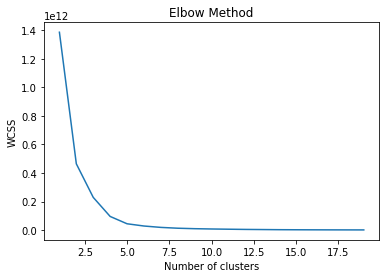

In [178]:
dtmp = copy.deepcopy(d_cit)
feat = [col for col in dtmp.columns if col!='city_id']
wcss = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(dtmp[feat])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

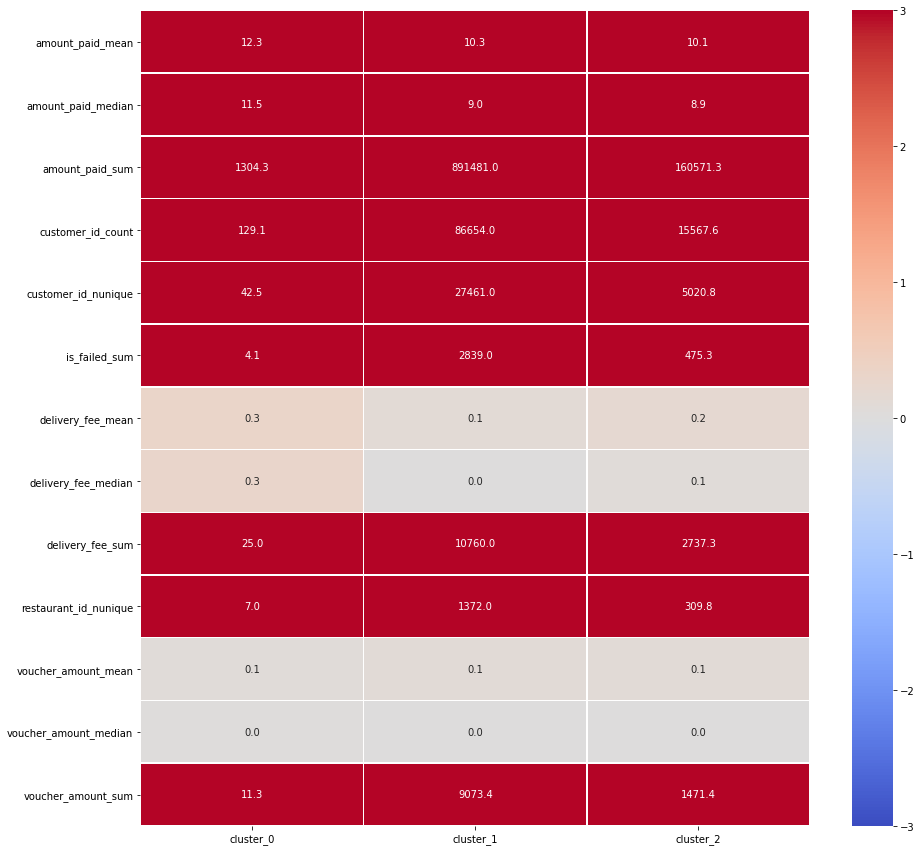

In [179]:
kmeans = KMeans(n_clusters=3,random_state= 42)
kmeans.fit(dtmp[feat])
dtmp['Cluster'] = kmeans.predict(dtmp[feat])

cluster_centers = kmeans.cluster_centers_.tolist()
cluster_centers_df = pd.DataFrame({i:centers for i, centers in enumerate(cluster_centers)}, index=feat)

figure_size = (15, 15)
fig, ax = plt.subplots(figsize=figure_size)

sns.heatmap(cluster_centers_df, 
            xticklabels=['cluster_' + str(i) for i in cluster_centers_df.columns], 
            yticklabels=list(cluster_centers_df.index),
            cmap='coolwarm',
            annot=True, fmt='.1f', linewidths = 0.5, ax=ax, 
            vmin=-3, vmax=3)
plt.show()

In [180]:
dtmp['Cluster'].value_counts()

0    3734
2      14
1       1
Name: Cluster, dtype: int64

In [181]:
silhouette_score(dtmp[feat], dtmp['Cluster'], metric='euclidean')

0.9822921849765937

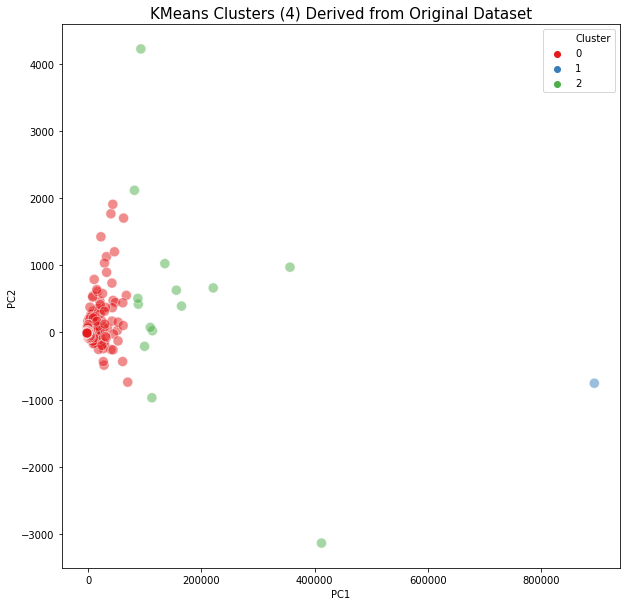

In [171]:
pca1 = PCA(n_components=2).fit(dtmp[feat])
pca2d = pca1.transform(dtmp[feat])

plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=dtmp['Cluster'], 
                palette='Set1',
                s=100, alpha=0.5).set_title('KMeans Clusters (4) Derived from Original Dataset', fontsize=15)

plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [172]:
d_cit['City_Cluster'] =  kmeans.predict(d_cit[feat])

In [174]:
df_merge = df_merge.merge(d_cit[['city_id','City_Cluster']],how='left')

__Restaurants__

In [163]:
dcust_v5 = copy.deepcopy(dcust)

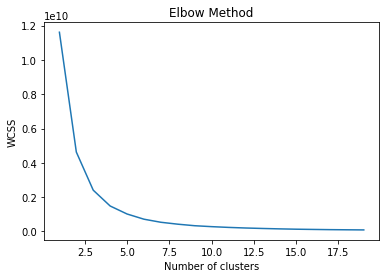

In [182]:
d_rest = df_merge.groupby('restaurant_id').agg({'amount_paid' : ['mean','median','sum'],
                                                           'customer_id' : ['count','nunique'],
                                                           'is_failed' : 'sum',
                                                            'delivery_fee' : ['mean','median','sum'],
                                                             'voucher_amount': ['mean','median','sum']
                                                           })

d_rest.columns=['_'.join(col) for col in d_rest.columns.ravel()]
d_rest.reset_index(inplace=True)

d_rest.fillna(0,inplace=True)

dtmp = copy.deepcopy(d_rest)
feat = [col for col in dtmp.columns if col!='restaurant_id']
wcss = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(dtmp[feat])
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

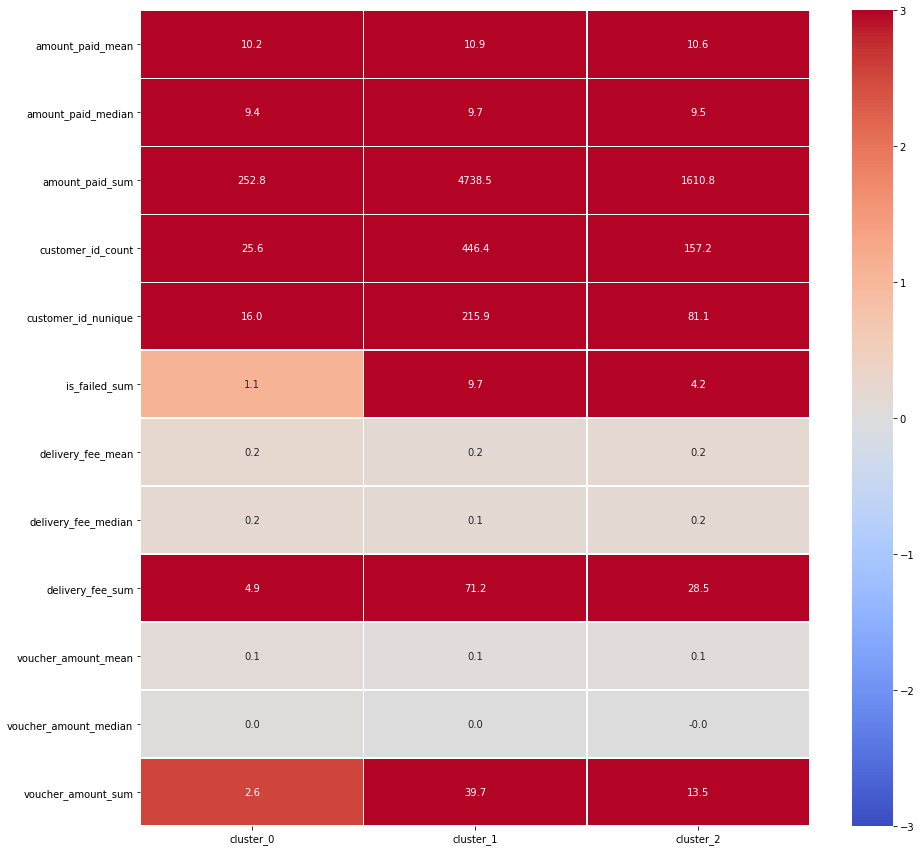

In [183]:
kmeans2 = KMeans(n_clusters=3,random_state= 42)
kmeans2.fit(dtmp[feat])
dtmp['Cluster'] = kmeans2.predict(dtmp[feat])

cluster_centers = kmeans2.cluster_centers_.tolist()
cluster_centers_df = pd.DataFrame({i:centers for i, centers in enumerate(cluster_centers)}, index=feat)

figure_size = (15, 15)
fig, ax = plt.subplots(figsize=figure_size)

sns.heatmap(cluster_centers_df, 
            xticklabels=['cluster_' + str(i) for i in cluster_centers_df.columns], 
            yticklabels=list(cluster_centers_df.index),
            cmap='coolwarm',
            annot=True, fmt='.1f', linewidths = 0.5, ax=ax, 
            vmin=-3, vmax=3)
plt.show()

In [184]:
dtmp['Cluster'].value_counts()

0    10917
2     2327
1      316
Name: Cluster, dtype: int64

In [185]:
silhouette_score(dtmp[feat], dtmp['Cluster'], metric='euclidean')

0.7185286152428801

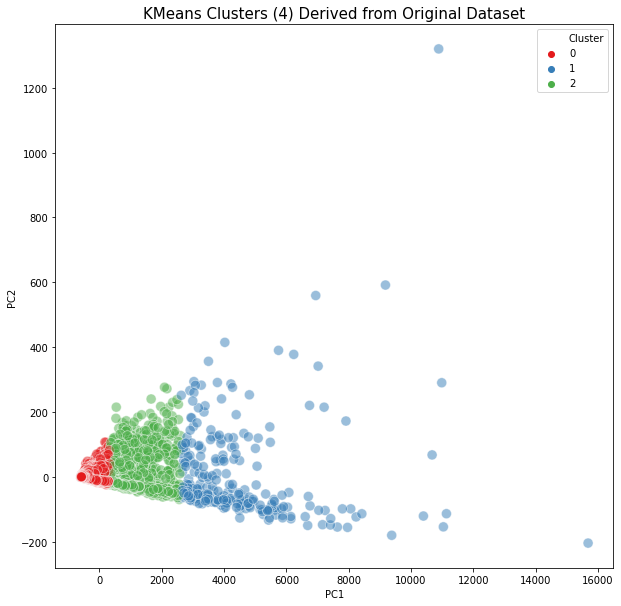

In [187]:
pca3 = PCA(n_components=2).fit(dtmp[feat])
pca2d = pca3.transform(dtmp[feat])

plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=dtmp['Cluster'], 
                palette='Set1',
                s=100, alpha=0.5).set_title('KMeans Clusters (4) Derived from Original Dataset', fontsize=15)

plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [197]:
d_rest['Restaurant_Cluster'] =  kmeans2.predict(d_rest[feat])
df_merge = df_merge.merge(d_rest[['restaurant_id','Restaurant_Cluster']],how='left')

__Adding City and Restaurant Related Features__

In [189]:
dcust_v6 = copy.deepcopy(dcust)

print(dcust.shape)

(245453, 220)


In [199]:
df_merge['Restaurant_Cluster'].value_counts()

2    366145
0    279344
1    141058
Name: Restaurant_Cluster, dtype: int64

In [200]:
for col in ['City_Cluster','Restaurant_Cluster']:
    d1 = df_merge.groupby(['customer_id',col]).agg({'amount_paid' : ['mean','median','sum'],
                                                       'customer_id' : 'count',
                                                       'is_failed' : 'sum',
                                                        'delivery_fee' : ['mean','median','sum']
                                                       })

    d1.columns=['_'.join(col) for col in d1.columns.ravel()]
    d1.reset_index(inplace=True)
    d1[col] = d1[col].astype('str')
    d2 = pd.pivot_table(d1, index = 'customer_id', columns=col, values = ['amount_paid_mean', 'amount_paid_median',
           'amount_paid_sum', 'customer_id_count', 'is_failed_sum'])

    d2.columns=['_'.join(col) for col in d2.columns.ravel()]

    d2.reset_index(inplace=True)

    d2.fillna(0, inplace = True)

    dcust=dcust.merge(d2, how = 'left', on = 'customer_id')

    print(dcust.shape)

(245453, 235)
(245453, 250)


In [201]:
list(dcust.columns)

['customer_id',
 'order_date_min',
 'order_date_max',
 'order_count',
 'customer_order_rank_max',
 'is_failed_sum',
 'voucher_amount_mean',
 'voucher_amount_median',
 'voucher_amount_sum',
 'delivery_fee_mean',
 'delivery_fee_median',
 'delivery_fee_sum',
 'amount_paid_mean',
 'amount_paid_median',
 'amount_paid_sum',
 'is_returning_customer',
 'city_id_nunique',
 'restaurant_id_nunique',
 'order_hour_min',
 'order_hour_max',
 'order_hour_median',
 'order_hour_nunique',
 'weekday_nunique',
 'Weekend_Flag_sum',
 'date_diff',
 'Recency',
 'R_score',
 'F_score',
 'M_score',
 'RFM_Score',
 'amount_paid_mean_1491',
 'amount_paid_mean_1523',
 'amount_paid_mean_1619',
 'amount_paid_mean_1779',
 'amount_paid_mean_1811',
 'amount_paid_median_1491',
 'amount_paid_median_1523',
 'amount_paid_median_1619',
 'amount_paid_median_1779',
 'amount_paid_median_1811',
 'amount_paid_sum_1491',
 'amount_paid_sum_1523',
 'amount_paid_sum_1619',
 'amount_paid_sum_1779',
 'amount_paid_sum_1811',
 'customer_id

In [202]:
categorical_columns

['restaurant_id',
 'city_id',
 'payment_id',
 'platform_id',
 'transmission_id',
 'weekday',
 'Weekend_Flag']

## Feature Selection

In [204]:
dcust_v7 = copy.deepcopy(dcust)

In [205]:
features = [c for c in dcust.columns if c not in ['customer_id','order_date_min,order_date_max','is_returning_customer']]
target =  'is_returning_customer'

__Correlation__

In [210]:
correlation_matrix = dcust[features].corr(method='spearman')

In [211]:
num_variables = len(correlation_matrix)
correlation_value = 0.60
correlated_variables = []

for row in range(1,num_variables):
    for col in range(0,row):
        if abs(correlation_matrix.iloc[row,col]) >= correlation_value:
            print('The variable {0} is correlated with the variable {1} by a factor of {2}'.format(list(correlation_matrix)[row], list(correlation_matrix)[col], correlation_matrix.iloc[row,col]))
            correlated_variables.append([list(correlation_matrix)[row], list(correlation_matrix)[col], correlation_matrix.iloc[row,col]])


The variable customer_order_rank_max is correlated with the variable order_count by a factor of 0.9835908495592898
The variable voucher_amount_median is correlated with the variable voucher_amount_mean by a factor of 0.8512241587107638
The variable voucher_amount_sum is correlated with the variable voucher_amount_mean by a factor of 0.9978984742261012
The variable voucher_amount_sum is correlated with the variable voucher_amount_median by a factor of 0.8292575255288304
The variable delivery_fee_median is correlated with the variable delivery_fee_mean by a factor of 0.9133945440014903
The variable delivery_fee_sum is correlated with the variable delivery_fee_mean by a factor of 0.9667826765660676
The variable delivery_fee_sum is correlated with the variable delivery_fee_median by a factor of 0.8210125913580437
The variable amount_paid_median is correlated with the variable amount_paid_mean by a factor of 0.9881094815642204
The variable amount_paid_sum is correlated with the variable ord

The variable amount_paid_mean_Saturday is correlated with the variable Weekend_Flag_sum by a factor of 0.6034197870665452
The variable amount_paid_mean_Sunday is correlated with the variable Weekend_Flag_sum by a factor of 0.7078012375149825
The variable amount_paid_median_Friday is correlated with the variable amount_paid_mean_Friday by a factor of 0.9997232683407652
The variable amount_paid_median_Monday is correlated with the variable amount_paid_mean_Monday by a factor of 0.9998914237582956
The variable amount_paid_median_Saturday is correlated with the variable Weekend_Flag_sum by a factor of 0.6022157810693151
The variable amount_paid_median_Saturday is correlated with the variable amount_paid_mean_Saturday by a factor of 0.9997328384240637
The variable amount_paid_median_Sunday is correlated with the variable Weekend_Flag_sum by a factor of 0.7052503022990528
The variable amount_paid_median_Sunday is correlated with the variable amount_paid_mean_Sunday by a factor of 0.999357172

In [212]:
correlated_variables = sorted(correlated_variables, key=lambda value: abs(value[-1]), reverse=True)
correlated_variables

[['amount_paid_median_22167', 'amount_paid_mean_22167', 1.0],
 ['amount_paid_median_22295', 'amount_paid_mean_22295', 1.0],
 ['amount_paid_sum_22167', 'amount_paid_mean_22167', 1.0],
 ['amount_paid_sum_22167', 'amount_paid_median_22167', 1.0],
 ['amount_paid_sum_22295', 'amount_paid_mean_22295', 1.0],
 ['amount_paid_sum_22295', 'amount_paid_median_22295', 1.0],
 ['customer_id_count_22295', 'amount_paid_mean_22295', 1.0],
 ['customer_id_count_22295', 'amount_paid_median_22295', 1.0],
 ['customer_id_count_22295', 'amount_paid_sum_22295', 1.0],
 ['amount_paid_median_2020', 'amount_paid_mean_2020', 1.0],
 ['amount_paid_sum_2020', 'amount_paid_mean_2020', 1.0],
 ['amount_paid_sum_2020', 'amount_paid_median_2020', 1.0],
 ['customer_id_count_2020', 'amount_paid_mean_2020', 1.0],
 ['customer_id_count_2020', 'amount_paid_median_2020', 1.0],
 ['customer_id_count_2020', 'amount_paid_sum_2020', 1.0],
 ['is_failed_sum_2020', 'amount_paid_mean_2020', 1.0],
 ['is_failed_sum_2020', 'amount_paid_median

In [213]:
columns_to_delete_correlation_target = []
for element in correlated_variables:
    if element[0] not in list(dcust) or element[1] not in list(dcust):
        break
    else:
        first = dcust.is_returning_customer.corr(dcust[element[0]], method='spearman')
        second = dcust.is_returning_customer.corr(dcust[element[1]], method='spearman')
        if abs(first) > abs(second):
            print('The variable {0} is more correlated with the target'.format(element[0]))
            columns_to_delete_correlation_target.append(element[1])
        else: 
            print('The variable {0} is more correlated with the target'.format(element[1]))
            columns_to_delete_correlation_target.append(element[0])
        print(str({element[0]: first, element[1]: second}))

columns_to_delete_correlation_target = list(set(columns_to_delete_correlation_target))
dcust.drop(columns_to_delete_correlation_target, axis=1, inplace=True)

The variable amount_paid_mean_22167 is more correlated with the target
{'amount_paid_median_22167': 0.0008959248041035878, 'amount_paid_mean_22167': 0.0008959248041035878}
The variable amount_paid_mean_22295 is more correlated with the target
{'amount_paid_median_22295': 0.0037339459016027523, 'amount_paid_mean_22295': 0.0037339459016027523}
The variable amount_paid_mean_22167 is more correlated with the target
{'amount_paid_sum_22167': 0.0008959248041035878, 'amount_paid_mean_22167': 0.0008959248041035878}
The variable amount_paid_median_22167 is more correlated with the target
{'amount_paid_sum_22167': 0.0008959248041035878, 'amount_paid_median_22167': 0.0008959248041035878}
The variable amount_paid_mean_22295 is more correlated with the target
{'amount_paid_sum_22295': 0.0037339459016027523, 'amount_paid_mean_22295': 0.0037339459016027523}
The variable amount_paid_median_22295 is more correlated with the target
{'amount_paid_sum_22295': 0.0037339459016027523, 'amount_paid_median_222

The variable amount_paid_median_30199 is more correlated with the target
{'amount_paid_sum_30199': -0.0006149796535212545, 'amount_paid_median_30199': -0.0006397472295427647}
The variable amount_paid_mean_4260 is more correlated with the target
{'amount_paid_median_4260': 0.06438838752993462, 'amount_paid_mean_4260': 0.06441275365085464}
The variable amount_paid_sum_1523 is more correlated with the target
{'amount_paid_sum_1523': 0.0470472167258175, 'amount_paid_mean_1523': 0.046999204243098225}
The variable amount_paid_sum_1523 is more correlated with the target
{'amount_paid_sum_1523': 0.0470472167258175, 'amount_paid_median_1523': 0.046997530912369086}
The variable customer_id_count_1523 is more correlated with the target
{'customer_id_count_1523': 0.047051147192717364, 'amount_paid_mean_1523': 0.046999204243098225}
The variable customer_id_count_1523 is more correlated with the target
{'customer_id_count_1523': 0.047051147192717364, 'amount_paid_median_1523': 0.046997530912369086}


The variable amount_paid_mean_1779 is more correlated with the target
{'amount_paid_median_1779': 0.11966997826360978, 'amount_paid_mean_1779': 0.12173625073818584}
The variable amount_paid_median_2_x is more correlated with the target
{'amount_paid_median_2_x': -0.003179510963134189, 'amount_paid_mean_2_x': -0.0010405269709687858}
The variable amount_paid_median_30391 is more correlated with the target
{'amount_paid_sum_30391': -0.012956771997266397, 'amount_paid_median_30391': -0.014187362817729532}
The variable amount_paid_sum_1811 is more correlated with the target
{'amount_paid_sum_1811': 0.0885743123589305, 'amount_paid_median_1811': 0.08650212641386133}
The variable customer_id_count_525 is more correlated with the target
{'customer_id_count_525': -0.0072709931477966516, 'amount_paid_sum_525': -0.007249078137336749}
The variable customer_id_count_525 is more correlated with the target
{'customer_id_count_525': -0.0072709931477966516, 'amount_paid_mean_525': -0.007251165283572261

The variable customer_id_count_Wednesday is more correlated with the target
{'customer_id_count_Wednesday': 0.2241708426304282, 'amount_paid_sum_Wednesday': 0.21947240366497586}
The variable customer_id_count_1491 is more correlated with the target
{'customer_id_count_1491': 0.051387995490792836, 'amount_paid_mean_1491': 0.04922560850022106}
The variable customer_id_count_1491 is more correlated with the target
{'customer_id_count_1491': 0.051387995490792836, 'amount_paid_median_1491': 0.04914354448517616}
The variable amount_paid_median_1_y is more correlated with the target
{'customer_id_count_1_y': -0.00548627156245356, 'amount_paid_median_1_y': -0.013131149266388942}
The variable customer_id_count_30359 is more correlated with the target
{'customer_id_count_30359': 0.09305197643545837, 'amount_paid_sum_30359': 0.08999107677773348}
The variable customer_id_count_30231 is more correlated with the target
{'customer_id_count_30231': 0.12475910444919218, 'amount_paid_sum_30231': 0.12266

The variable customer_id_count_29815 is more correlated with the target
{'customer_id_count_29815': 0.0937372135199857, 'amount_paid_mean_29815': 0.07087367507935446}
The variable customer_id_count_Monday is more correlated with the target
{'customer_id_count_Monday': 0.22542496107424875, 'amount_paid_median_Monday': 0.20189378146618048}
The variable customer_id_count_Thursday is more correlated with the target
{'customer_id_count_Thursday': 0.22912996755803602, 'amount_paid_mean_Thursday': 0.20455250895533125}
The variable customer_id_count_29815 is more correlated with the target
{'customer_id_count_29815': 0.0937372135199857, 'amount_paid_median_29815': 0.06952451921571216}
The variable customer_id_count_30359 is more correlated with the target
{'customer_id_count_30359': 0.09305197643545837, 'amount_paid_mean_30359': 0.07299166465406325}
The variable customer_id_count_29463 is more correlated with the target
{'customer_id_count_29463': 0.09636043136560213, 'amount_paid_sum_29463': 

The variable customer_order_rank_max is more correlated with the target
{'weekday_nunique': 0.3933833197599235, 'customer_order_rank_max': 0.40948431233407784}
The variable customer_id_count_4324 is more correlated with the target
{'customer_id_count_4324': 0.160095105489522, 'amount_paid_mean_4324': 0.10261716592816475}
The variable customer_id_count_29463 is more correlated with the target
{'customer_id_count_29463': 0.09636043136560213, 'amount_paid_mean_29463': 0.04128391850788079}
The variable customer_id_count_4324 is more correlated with the target
{'customer_id_count_4324': 0.160095105489522, 'amount_paid_median_4324': 0.10001691966712785}
The variable customer_id_count_29463 is more correlated with the target
{'customer_id_count_29463': 0.09636043136560213, 'amount_paid_median_29463': 0.03881000028960858}
The variable weekday_nunique is more correlated with the target
{'F_score': 0.388023253204319, 'weekday_nunique': 0.3933833197599235}
The variable amount_paid_sum_4356 is mor

The variable order_count is more correlated with the target
{'M_score': 0.3070984869695738, 'order_count': 0.4028404865042404}
The variable amount_paid_sum_1_x is more correlated with the target
{'amount_paid_sum_1_x': 0.26008090853969146, 'amount_paid_sum_Sunday': 0.24253824278369893}
The variable is_failed_sum is more correlated with the target
{'is_failed_sum_0_y': 0.13227860814009282, 'is_failed_sum': 0.16511045247636438}
The variable F_score is more correlated with the target
{'M_score': 0.3070984869695738, 'F_score': 0.388023253204319}
The variable Weekend_Flag_sum is more correlated with the target
{'amount_paid_sum_Sunday': 0.24253824278369893, 'Weekend_Flag_sum': 0.28208064816600703}
The variable customer_id_count_1_x is more correlated with the target
{'customer_id_count_1_x': 0.28208064816600703, 'amount_paid_sum_Sunday': 0.24253824278369893}
The variable customer_order_rank_max is more correlated with the target
{'M_score': 0.3070984869695738, 'customer_order_rank_max': 0.4

The variable customer_id_count_0_y is more correlated with the target
{'customer_id_count_0_y': 0.17391448662511136, 'amount_paid_sum_2_x': 0.033518731040255025}
The variable amount_paid_sum_1_x is more correlated with the target
{'amount_paid_sum_1_x': 0.26008090853969146, 'amount_paid_sum_Saturday': 0.21385920772772424}
The variable Weekend_Flag_sum is more correlated with the target
{'amount_paid_sum_Saturday': 0.21385920772772424, 'Weekend_Flag_sum': 0.28208064816600703}
The variable customer_id_count_1_x is more correlated with the target
{'customer_id_count_1_x': 0.28208064816600703, 'amount_paid_sum_Saturday': 0.21385920772772424}
The variable customer_id_count_2_x is more correlated with the target
{'customer_id_count_2_x': 0.03638781897060718, 'amount_paid_median_0_y': 0.008658515459949659}
The variable amount_paid_median_0_y is more correlated with the target
{'amount_paid_median_2_x': -0.003179510963134189, 'amount_paid_median_0_y': 0.008658515459949659}
The variable amount_

In [214]:
dcust.shape

(245453, 86)

__Zero Importance Feature Elimination__

In [227]:
features = [c for c in dcust.columns if c not in ['customer_id','order_date_min','order_date_max','is_returning_customer']]

In [232]:
dcust['RFM_Score'] = dcust['RFM_Score'].astype('int32')

In [233]:
X_train, X_test, y_train, y_test = train_test_split(dcust[features],dcust[target],stratify=dcust[target],
                                               test_size=0.2,random_state=42)

In [234]:
from lightgbm import LGBMClassifier

In [236]:
feature_importances = np.zeros(X_train[features].shape[1])

# Create the model with several hyperparameters


for i in range(10):
    
    model = LGBMClassifier(objective='binary', boosting_type = 'gbdt', n_estimators = 500,random_state=i)

    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(X_train[features], y_train, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'logloss', verbose = 0)
    
    # Record the feature importances
    feature_importances += model.feature_importances_
    
feature_importances = feature_importances / 10
feature_importances = pd.DataFrame({'feature': list(X_train[features].columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))


There are 15 features with 0.0 importance


In [237]:
features=[col for col in features if col not in zero_features]

In [241]:
len(features)

67

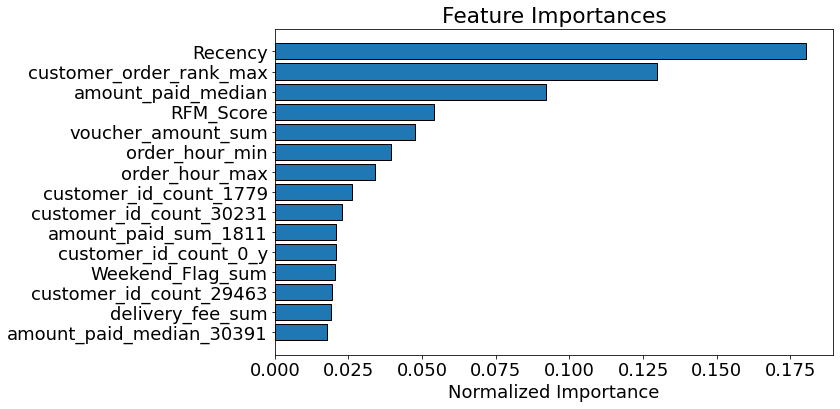

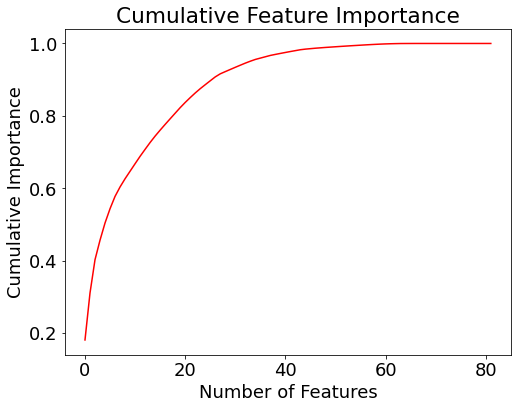

43 features required for 0.98 of cumulative importance


In [242]:
norm_feature_importances = plot_feature_importances(feature_importances,0.98)

In [243]:
threshold = 0.98

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])
features=features_to_keep

In [244]:
len(features)

42

## Modelling Part

In [245]:
X_train, X_test, y_train, y_test = train_test_split(dcust[features],dcust[target],stratify=dcust[target],
                                               test_size=0.2,random_state=42)

__Model with the base Model Parameters__

In [246]:
n = ytrain.value_counts()
model_base2 = CatBoostClassifier(
                           learning_rate=.1,
                           iterations=1000,
                           max_depth=5,
                           l2_leaf_reg=1,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]], custom_loss=['AUC'])

model_base2.fit(
    X_train, ytrain,
    eval_set=(X_test, ytest),
    plot = True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6592117	test: 0.6594435	best: 0.6594435 (0)	total: 41.3ms	remaining: 41.2s
1:	learn: 0.6323133	test: 0.6328023	best: 0.6328023 (1)	total: 79.9ms	remaining: 39.9s
2:	learn: 0.6102140	test: 0.6107903	best: 0.6107903 (2)	total: 122ms	remaining: 40.6s
3:	learn: 0.5930772	test: 0.5937482	best: 0.5937482 (3)	total: 167ms	remaining: 41.6s
4:	learn: 0.5794408	test: 0.5802850	best: 0.5802850 (4)	total: 209ms	remaining: 41.6s
5:	learn: 0.5688126	test: 0.5698203	best: 0.5698203 (5)	total: 248ms	remaining: 41s
6:	learn: 0.5607430	test: 0.5618131	best: 0.5618131 (6)	total: 288ms	remaining: 40.9s
7:	learn: 0.5529162	test: 0.5540183	best: 0.5540183 (7)	total: 331ms	remaining: 41.1s
8:	learn: 0.5481059	test: 0.5493409	best: 0.5493409 (8)	total: 372ms	remaining: 40.9s
9:	learn: 0.5435861	test: 0.5448671	best: 0.5448671 (9)	total: 411ms	remaining: 40.7s
10:	learn: 0.5402197	test: 0.5415546	best: 0.5415546 (10)	total: 453ms	remaining: 40.7s
11:	learn: 0.5369496	test: 0.5382786	best: 0.5382786

94:	learn: 0.5138746	test: 0.5165173	best: 0.5165173 (94)	total: 3.8s	remaining: 36.2s
95:	learn: 0.5138349	test: 0.5164868	best: 0.5164868 (95)	total: 3.84s	remaining: 36.2s
96:	learn: 0.5137957	test: 0.5164665	best: 0.5164665 (96)	total: 3.88s	remaining: 36.1s
97:	learn: 0.5137720	test: 0.5164592	best: 0.5164592 (97)	total: 3.91s	remaining: 36s
98:	learn: 0.5137008	test: 0.5164131	best: 0.5164131 (98)	total: 3.94s	remaining: 35.8s
99:	learn: 0.5136771	test: 0.5163931	best: 0.5163931 (99)	total: 3.97s	remaining: 35.7s
100:	learn: 0.5136488	test: 0.5163713	best: 0.5163713 (100)	total: 4.02s	remaining: 35.7s
101:	learn: 0.5136081	test: 0.5163710	best: 0.5163710 (101)	total: 4.05s	remaining: 35.7s
102:	learn: 0.5135873	test: 0.5163627	best: 0.5163627 (102)	total: 4.08s	remaining: 35.6s
103:	learn: 0.5135720	test: 0.5163543	best: 0.5163543 (103)	total: 4.12s	remaining: 35.5s
104:	learn: 0.5135580	test: 0.5163438	best: 0.5163438 (104)	total: 4.15s	remaining: 35.4s
105:	learn: 0.5135263	tes

190:	learn: 0.5101033	test: 0.5154198	best: 0.5154101 (187)	total: 7.6s	remaining: 32.2s
191:	learn: 0.5100434	test: 0.5154060	best: 0.5154060 (191)	total: 7.64s	remaining: 32.2s
192:	learn: 0.5099997	test: 0.5154069	best: 0.5154060 (191)	total: 7.69s	remaining: 32.2s
193:	learn: 0.5099709	test: 0.5153796	best: 0.5153796 (193)	total: 7.74s	remaining: 32.1s
194:	learn: 0.5099310	test: 0.5153725	best: 0.5153725 (194)	total: 7.79s	remaining: 32.2s
195:	learn: 0.5098825	test: 0.5153829	best: 0.5153725 (194)	total: 7.84s	remaining: 32.2s
196:	learn: 0.5098580	test: 0.5153825	best: 0.5153725 (194)	total: 7.88s	remaining: 32.1s
197:	learn: 0.5098136	test: 0.5153964	best: 0.5153725 (194)	total: 7.93s	remaining: 32.1s
198:	learn: 0.5097839	test: 0.5153883	best: 0.5153725 (194)	total: 7.97s	remaining: 32.1s
199:	learn: 0.5097484	test: 0.5153623	best: 0.5153623 (199)	total: 8.01s	remaining: 32s
200:	learn: 0.5097026	test: 0.5153655	best: 0.5153623 (199)	total: 8.05s	remaining: 32s
201:	learn: 0.5

284:	learn: 0.5075308	test: 0.5152060	best: 0.5151432 (268)	total: 11.5s	remaining: 28.8s
285:	learn: 0.5074689	test: 0.5152066	best: 0.5151432 (268)	total: 11.5s	remaining: 28.7s
286:	learn: 0.5074586	test: 0.5152084	best: 0.5151432 (268)	total: 11.5s	remaining: 28.7s
287:	learn: 0.5074365	test: 0.5152040	best: 0.5151432 (268)	total: 11.6s	remaining: 28.7s
288:	learn: 0.5074054	test: 0.5152058	best: 0.5151432 (268)	total: 11.6s	remaining: 28.6s
289:	learn: 0.5073967	test: 0.5152062	best: 0.5151432 (268)	total: 11.7s	remaining: 28.6s
290:	learn: 0.5073704	test: 0.5152026	best: 0.5151432 (268)	total: 11.7s	remaining: 28.6s
291:	learn: 0.5073437	test: 0.5151983	best: 0.5151432 (268)	total: 11.8s	remaining: 28.5s
292:	learn: 0.5073353	test: 0.5151911	best: 0.5151432 (268)	total: 11.8s	remaining: 28.5s
293:	learn: 0.5073057	test: 0.5152059	best: 0.5151432 (268)	total: 11.8s	remaining: 28.4s
294:	learn: 0.5072660	test: 0.5152056	best: 0.5151432 (268)	total: 11.9s	remaining: 28.4s
295:	learn

Train recall:  0.6876857940726061
Test recall:  0.6774164489685613 

Train precision:  0.5172962900220227
Test precision:  0.5138366928595832 

Train accuracy:  0.7842657948075493
Test accuracy:  0.7821189220019963 



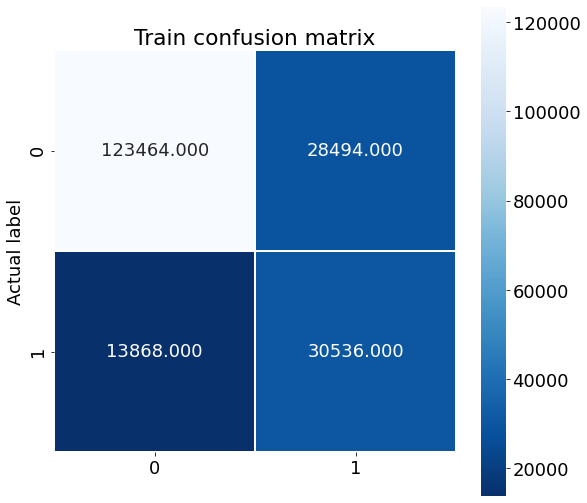

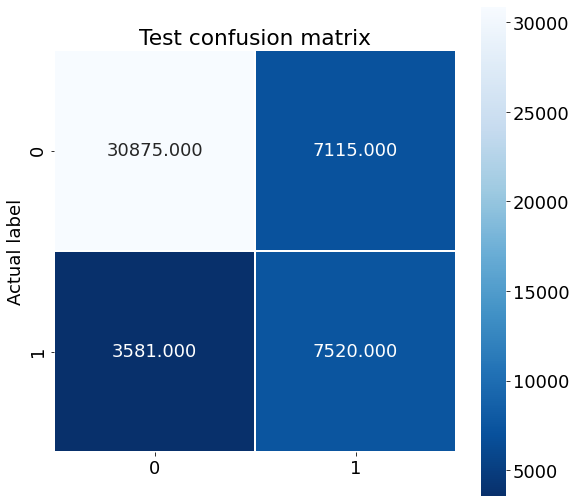

In [248]:
metric_check(model_base2,X_train,X_test,ytrain,ytest)

__Random Search with LGBM__

In [254]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(2, 50), 
             'min_child_samples': sp_randint(100, 1000), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1,1.2, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1,1.2, 5, 10, 20, 50, 100],
             'learning_rate':[0.03,0.04,0.05,0.07,0.1,0.12,0.15,0.25,0.35,0.4],
            'n_estimators':[50,100,200,300,400,500,600],
            'max_depth':[2,3,4,5,6,8,10],
            'max_bin':[50,100,195,255,350]}


n_HP_points_to_test = 300

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(random_state=314, silent=True, metric='logloss', n_jobs=-1)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=11,
    verbose=True,n_jobs=-1)

In [255]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 17.6min finished


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(metric='logloss', random_state=314),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023E2D126348>,
                                        'learning_rate': [0.03, 0.04, 0.05,
                                                          0.07, 0.1, 0.12, 0.15,
                                                          0.25, 0.35, 0.4],
                                        'max_bin': [50, 100, 195, 255, 350],
                                        'max_depth': [2, 3, 4, 5, 6, 8, 10],
                                        'min_ch...
                                                             10000.0],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500, 600],
                                        'num_leaves': <sci

In [256]:
X_train, X_test, y_train, y_test = train_test_split(dcust[features],dcust[target],stratify=dcust[target],
                                               test_size=0.2,random_state=42)

Train recall:  0.4364021259346005
Test recall:  0.42572741194486985 

Train precision:  0.7442771547088647
Test precision:  0.7429649426190851 

Train accuracy:  0.8386449516708936
Test accuracy:  0.8368336354932676 



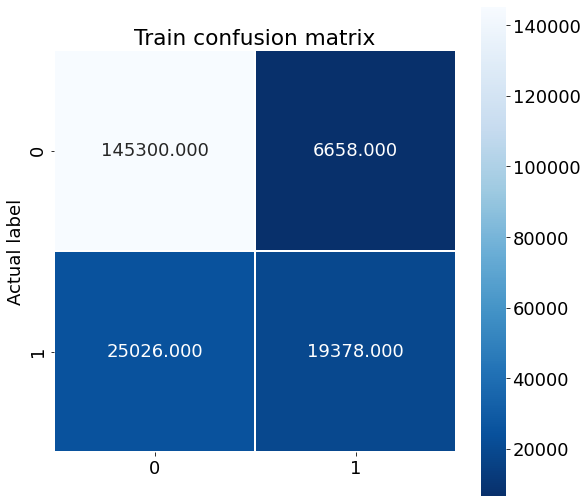

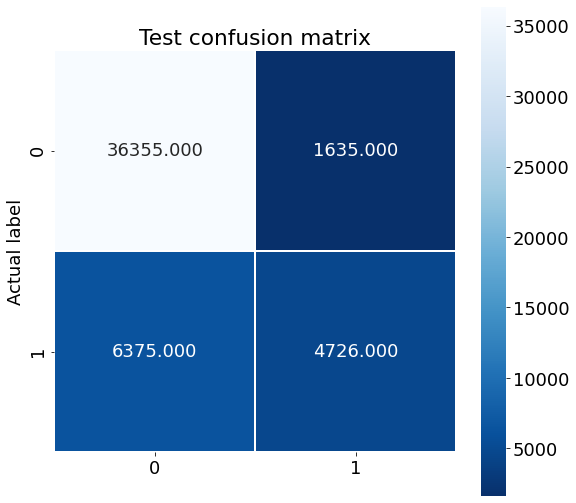

In [257]:
metric_check(gs.best_estimator_,X_train,X_test,ytrain,ytest)

In [ ]:
i